# Анализ рынка игровой индустрии

## Описание проекта

Случай аналитика в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности - это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

Данные представлены до 2016 года. Представим, что сейчас декабрь 2016 г., и идет палнирование кампании на 2017-й. Нужно отработать принцип работы с данными. 

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Важная ремарка:** Данные за 2016 год могут быть неполными.

In [1]:
# импорт библиотек
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

## Изучение данных

Прочитаем файл и получим общую информацию о данных.

In [2]:
# чтение файла
data = pd.read_csv('/Users/danilvlasenko/Desktop/projects_datasets/games.csv')

In [3]:
# получение общей информации о данных и первых 10 строк
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
# получение статистической информации о данных
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


**Первые выводы:**

Данные содержат всего 16715 строк, представлено 11 столбцов:
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

В данных содержатся следующие недочеты:
- 1) Присутствие верхнего регистра в наименовании столбцов - необходимо переименование;
- 2) Наличие пропусков в столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating` - необходим анализ и предобработка;
- 3) Некорректные типы данных в столбцах `Year_of_Release` (должен быть *int*, тк тут указан год релиза. Если выведем дату и из нее года, то будет как раз *int*), `User_Score` (должен быть *float*, тк тут дробная оценка от 0 до 10 и она не попала в describe), `Critic_Score` (стоит поставить *int*, тк оценка целое число от 0 до 100 и оно не попало в describe) - необходима замена типов данных;
- 4) Не совсем понятно. что значит, например, буква E в рейтинге ESRB - стоит изучить отдельно;
- 5) Присутствие верхнего регистра в столбцах `Name`, `Platform` и `Genre` - есть вероятность присутствия неявных дубликатов - необходимо приведение к нижнему регистру.

## Предобработка данных

**Отработаем п. 1 предварительных выводов**

Переиненуем столбцы с данными и приведем все наименования к одному регистру

In [5]:
# переименование столбцов
data = data.rename(columns = {'Name':'name',
                              'Platform':'platform',
                              'Year_of_Release':'year_of_release',
                              'Genre':'genre',
                              'NA_sales':'na_sales',
                              'EU_sales':'eu_sales',
                              'JP_sales':'jp_sales',
                              'Other_sales':'other_sales',
                              'Critic_Score':'critic_score',
                              'User_Score':'user_score',
                              'Rating':'esrb_rating',
                             }
                  )

# проверка изменений заголовков
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'esrb_rating'],
      dtype='object')

### Обработка пропусков

**Отработаем п. 2 предварительных выводов**

Посмотрим на количество пропусков в столбцах и детальнее каждый столбец.

In [6]:
# просмотр количества пропусков
data.isna().sum().sort_values()

platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
name                  2
genre                 2
year_of_release     269
user_score         6701
esrb_rating        6766
critic_score       8578
dtype: int64

В столбцах `name` и `genre` - отсутствуют по 2 значения. Заполнить эти пропуски не получится. Посмотрим детальнее на эти строки, и если окажется, что пропуски присутствуют в этих столбцах одновременно, удалим эти строки.

In [7]:
data[(data['genre'].isna()) & (data['name'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Действительно, это 2 безымянные игры и не определенного жанра, выпущены в 1993-ем. Продажи очень малы (всего 2,34 млн копий на 2 игры), какие-либо оценки в принципе отсутствуют. Такие цифры не исказят общую статистику, удалим эти 2 строки из данных

In [8]:
# удаление игр с неопределенным именем и жанром
data.dropna(subset=['genre', 'name'], inplace=True)

# проверка удаления
data.isna().sum().sort_values()

name                  0
platform              0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
year_of_release     269
user_score         6699
esrb_rating        6764
critic_score       8576
dtype: int64

Теперь по остальным столбцам:
- `year_of_release` - заполним техническим значением -1. В срезы в будущем эти значения не попадут, но мы сможем изменить тип данных на *int* для удобства. Если заполним средним или наиболее частым годом, реальная картина может исказиться. Дополнительный нюанс - одна и та же игра может выходить с разрывом в годы на разных платформах (например, эксклюзивы PS4 в виде Horizon или God of War недавно начали выходить на ПК, при этом изначально выпущены года 3-4 назад).
- `user_score` - заполнять не стоит. Оценка пользователей может отсутствовать по причине давности выпуска игры - до Интернета игры продавались в виде катриджей/карточек в магазинах, и оценка от пользователей, скорее всего, не собиралась. В наше время уже существует множество онлайн-площадок, где можно открыто поделиться мнением. Также стоит детальнее посмотреть на уникальные значения этого столбца
- `esrb_rating` - отсутствие значений можно объяснить 2-мя причинами. Первая - тем, что некоторые игры были выпущены в принципе до создания ESRB. В данных присутствуют релизы от 1980-го, при этом организация была основана только в 1994-ом. За эти 14 лет играм рейтинг не присуждался. Вторая причина - если игра кросс-платформенная, возможен вариант что на одной платформе рейтинг мог быть присвоен, а на другой нет. Также рейтинги на разных платформах могут и отличаться. Заполним пропуски значением *out of rating*.
- `critic_score` - заполнять не стоит. Средняя или медианная оценка критиков, даже если сгруппировать по жанру, может исказить реальную картину - незаслуженно поднять оценки неудавшимся релизам.

In [9]:
# заполнение пропусков столбца year_of_release техническим значением -1
data['year_of_release'] = data['year_of_release'].fillna(-1)

# заполнение пропусков столбца raing значением 'out of rating'
data['esrb_rating'] = data['esrb_rating'].fillna('out of rating')

# проверка заполнения пропусков
data.isna().sum().sort_values()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
esrb_rating           0
user_score         6699
critic_score       8576
dtype: int64

In [10]:
# проверка столбца critic_score по уникальным значениям
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Наблюдаем nan - не обращаем внимания, так как пропуски по столбцу не заполнялись.

Среди уникальных значений наблюдается неопознанное значение tbd.

В случае игровой индустрии, аббревиатура TBD переводится как To Be Determined или To Be Decided, то есть "будет решено". Чаще всего она применяется к датам выхода игр после их анонса где-нибудь на E3 или Gamescom, когда разработчики не могут решиться на официальную дату релиза, или они постоянно генерят новые идеи и не знают, когда все смогут реализовать.

Похожую мысль можно транслировать и на оценку пользователями - данных или количества оценок для корректной общей оценки игры может быть недостаточно - либо игра слишком новая, либо слишком непопулярная. Посмотрим, сколько раз TBD фигурировала в данных.

In [11]:
# проверка количества значений
data[data['user_score'] == 'tbd']['user_score'].count()

2424

Таких значений 2424. Для удаления слишком много. Заполним данные значения пропусками, так как оценка так же не определена точно и не может быть усреднена.

In [12]:
# заполнение значений tbd пропусками
data['user_score'] = data['user_score'].replace('tbd', np.NaN)

# проверка заполнения
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

### Изменение типов данных

**Отработаем п. 3 предварительных выводов**

Изменим типы данных в столбцах с некорректными типами:
- year_of_release - вполне подойдет int,
- user_score - на float,
- critic_score - на int.

Во всех указанных столбцах сознательно не удалены пропуски, будем их игнорировать при методе .astype()

In [13]:
# изменение типов данных
data['year_of_release'] = data['year_of_release'].astype('int64')

data['user_score'] = data['user_score'].astype('float64', errors='ignore')
data['critic_score'] = data['critic_score'].astype('int64', errors='ignore')

# проверка изменения
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  esrb_rating      16713 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,out of rating
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,out of rating
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,out of rating
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,out of rating


**Отработаем п. 4 предварительных выводов**

Для начала посмотрим, какие рейтинги в принципе присвоены играм по ESRB.

In [14]:
data['esrb_rating'].unique()

array(['E', 'out of rating', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Имеем следующие рейтинги:
- E - Для всех;
- M - Для взрослых (17+ лет);
- T - Подросткам (13+ лет);
- E10+ - Для всех от 10 лет и старше;
- K-A - Kids to Adults. Такого рейтинга сейчас нет, его заменяет E;
- AO - Только для взрослых (18+ лет, выше чем M);
- EC - Для детей младшего возраста (от 3 лет);
- RP - Рейтинг ожидается, обычно применяется ДО релиза игр.

Добавлять отдельный столбец все же нет сильной необходимости, данные пояснения запомним, это позволит написать более понятные выводы при изучении зависимостей продаж от присвоенного рейтинга. Вернемся к этому описанию в разделе по портрету пользователей.

In [15]:
# замена значений K-A на E в столбце esrb_rating
data['esrb_rating'] = data['esrb_rating'].replace('K-A', 'E')

# проверка уникальных значений в esrb_rating
data['esrb_rating'].unique()

array(['E', 'out of rating', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'],
      dtype=object)

**Отработаем п. 5 предварительных выводов**

Изменим регистр в столбцах `name`, `platform` и `genre` на нижний

In [16]:
# изменение регистра
data['name'] = data['name'].str.lower()
data['platform'] = data['platform'].str.lower()
data['genre'] = data['genre'].str.lower()

# проверка изменения
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,out of rating
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,out of rating
5,tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,out of rating
6,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,wii play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,new super mario bros. wii,wii,2009,platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,duck hunt,nes,1984,shooter,26.93,0.63,0.28,0.47,NaN,NaN,out of rating


Регистр изменили. Теперь проверим уникальные значения на предмет наличия неявных дубликатов

In [17]:
# проверка стролбца name
data['name'].unique()

array(['wii sports', 'super mario bros.', 'mario kart wii', ...,
       'woody woodpecker in crazy castle 5', 'lma manager 2007',
       'haitaka no psychedelica'], dtype=object)

In [18]:
# проверка столбца platform
data['platform'].unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

Видим странные названия *ps* и *xb* (Playstation или Xbox) при наличии отдельных приставок ps2-ps4 и x360-xone. Предположений 2: либо это самые первые поколения данных приставок, либо есть дубликаты.

Посмотрим подробнее эти строки. Если даты релизов для ps окажутся до 2006-го и для xb до 2009-го, то это не дубликаты - это реально вышедшие игры на первые поколения. Почему 2006-ой и 2009-ый - это официальные даты прекращения поддержки приставок со стороны Sony и Microsoft.

In [19]:
# срез данных по ps
ps_data = data.query('platform == "ps"')

# проверка годов релиза игр на ps
ps_data['year_of_release'].unique()

array([1997, 1999, 1998, 1996, 2000, 1995, 2001, 2002,   -1, 1994, 2003])

Это действительно ps1. Все релизы не позже 2003-го.

In [20]:
# срез данных по xbox
xb_data = data.query('platform == "xb"')

# проверка годов релиза на xb
xb_data['year_of_release'].unique()

array([2004, 2001, 2002, 2003, 2005,   -1, 2006, 2000, 2007, 2008])

Это действительно самый первый xbox. Все релизы не позже 2008-го.

In [21]:
# проврека столбца genre
data['genre'].unique()

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy'], dtype=object)

Дубликатов в столбце `genre` не замечено.

Напоследок, проверим все данные на наличие полных дубликатов.

In [22]:
# проверка датасета на наличие дубликатов
data.duplicated().sum()

0

**Теперь добавим новый столбец с общим количеством проданных копий по каждой игре**

In [23]:
# добавление столбца total_sales
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb_rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,out of rating,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,out of rating,31.38
5,tetris,gb,1989,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,out of rating,30.26
6,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,wii play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,new super mario bros. wii,wii,2009,platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,duck hunt,nes,1984,shooter,26.93,0.63,0.28,0.47,NaN,NaN,out of rating,28.31


**Выводы по предобработке** 

Преобработка данные произведена, датасет готов к дальнейшему анализу.

- 1) Столбцы переименованы на корректные;
- 2) Пропуски в уместных местах заполнены, в некоторых столбцах оставлены сознательно по причине невозможности заполнения;
- 3) Типы данные изменены;
- 4) Изучено, что представляют из себя рейтинги ESRB, принято решение не добавлять дополнительные пояснения в сам датасет;
- 5) Регистры в столбцах изменены, дубликаты в данных отсутствуют;
- 6) Добавлен новый столбец с общей суммой мировых продаж по каждой игре.

## Исследовательский анализ данных

На этапе исследовательского анализа ответим на следующие вопросы:
- 1) Сколько игр было выпущено за каждый год и какие налюдаются тренды?
- 2) Какие платформы являлись самыми популярными и какой характерный срок жизни платформ на рынке?
- 3) Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциальных прибыльных платформ.
- 4) Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Какие результаты получатся и как их можно интерпретировать?
- 5) Насколько оценки критиков и игроков влияют на продажи игр, и связаны ли оценки критиков с оценками игроков (посмотреть корреляцию на самой популярной платформе)?
- 6) Какие жанры игр являются самыми популярными?

**Вопрос 1**

Посмотрим, сколько игр было выпущено за каждый год и какие наблюдаются тренды.

Text(0.5, 1.0, 'Распределение релизов игр по годам')

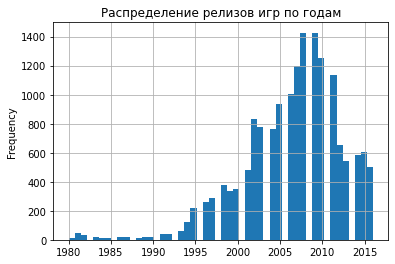

In [24]:
# построение графика по вопросу 1. Не считаем те игры, где не опрдеделен год релиза
data[data['year_of_release'] != -1]['year_of_release'].plot(kind='hist',
                                                                bins=50,
                                                                grid=True
                                                               )

plt.title('Распределение релизов игр по годам')

**Вывод по вопросу 1:** Игровая индустрия зародилась в начале 80-ых. Начиная с 90-ых, с момента резкого развития технологий, индустрия стремительно набирала обороты до конца 00-ых. Затем с 2010-го наблюдатеся спад релизов - примерно в этот период начали появляться более функциональные смартфоны, могу предположить что произошел фокус именно на мобильные платформы и разработчики стали выпускать больше игр на Android и iOS (к сожалению, отсутствуют в датасете :( , было бы интересно проверить ).

*Оффтоп*: на самом деле, так и есть. Громких и крутых релизов в последнее время происходит крайне мало, наблюдаются тренды на ремастеры давно вышедших игр при отсутствии новых и "налог на некстген" (доплата за графику уже ранее купленных игр. Например, PS5-версия игры, купленной ранее на PS4, составялет по миру в среднем $10). Также наблюдается серьезный дефицит платформ вследствие кризиса полупроводников - PS5 и Xbox Series X/S, видеокарты для ПК.

**Вопрос 2**

Построим график распределения суммарных продаж по платформам и выберем самые популярные.

Text(0.5, 1.0, 'Суммарные продажи игр по каждой платформе (в млн копий)')

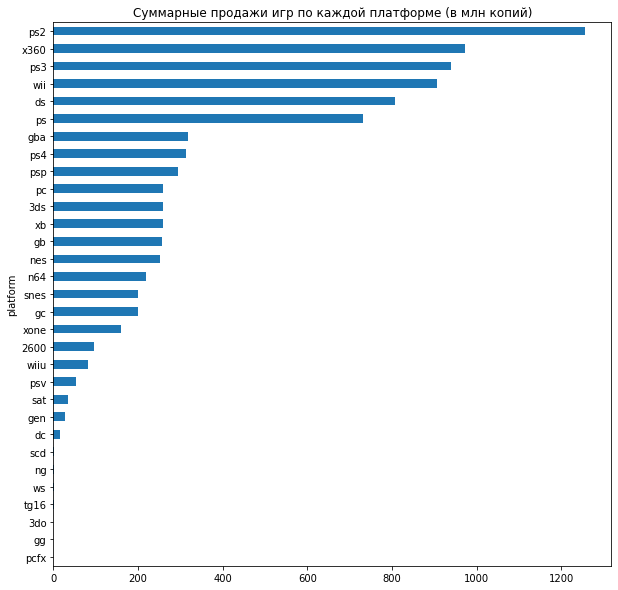

In [25]:
# построение графиков по вопросу 2
data.groupby('platform')['total_sales'].sum().sort_values().plot(kind='barh',
                                                                 figsize=(10, 10)
                                                                )

plt.title('Суммарные продажи игр по каждой платформе (в млн копий)')

Безоговорочным лидером является **PS2**, на нее продано больше всего игр (более 1,2 млрд копий). В тот момент это было что-то новое, впервые появились 3D-игры от 3 лица (те же GTA Vice City и San Andreas).

Затем идут игры прошедшего 7 поколения консолей на момент выгрузки данных в 2015 г. - это **Xbox360**, **PS3**, **Nintendo Wii** и карманная консоль **Nintendo DS**. Также среди лидеров находится самая первая **PS** - на тот момент рынок резко вырос, и приставка была чем-то новым (первая PS вышла раньше первого XBox, который проиграл более чем в 2 раза).

На момент 2015 г. уже вышли консоли 8 поколения **PS4** и **Xbox One** и переход между поколениями был в активной стадии, поэтому отставание 8 поколения от 7-го можно объяснить.

Внизу рейтинга расположены японские консоли - их низкая популярность может быть обсуловлена выходом только на локальном японском рынке - лишь малая часть на фоне мирового.

Выберем самые популярные платформы из графика выше и сфорируем отдельный список, затем построим динамику продаж по годам - это возволит ответить на 2 часть вопроса - какой характерный срок жизни платформ на рынке?

P.S. Не стоит путать с периодом именно релиза новых поколений, не все сразу бегут за новой приставкой. Некоторые при выходе нового поколения только покупают предыдущее и играют в самые топовые игры поколения.

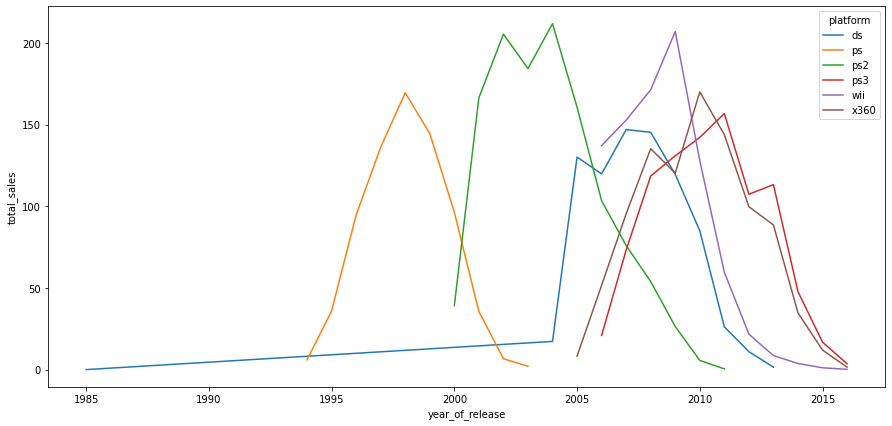

In [26]:
# создание списка самых популярных платформ. Их 6
top_platforms_global = ['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps']

# получение сводной таблицы по каждой платформе и суммы продаж по годам
data_top_platforms = data.query('platform == @top_platforms_global and year_of_release != -1')
data_to_plot = data_top_platforms.pivot_table(index = ['platform', 'year_of_release'], 
                                              values = 'total_sales', 
                                              aggfunc = 'sum'
                                             )

# построение линейного графика по каждой платформе топ-6
# получилось построить через seaborn
plot = sns.lineplot(data = data_to_plot.reset_index(),
                    x = 'year_of_release',
                    y = 'total_sales',
                    hue = 'platform',
                    )
plot.figure.set_figwidth(15)
plot.figure.set_figheight(7)

Исходя из графика, получаем следующие сроки жизни платформ:
- **Nintendo DS** - первый релиз в 1985-ом, затем резкий скачок в 2004-ом. Могу предположить, что данных по продажам не собирались до 2004-го - поэтому сроком активной "жизни" считаем период именно с 2004-го. Платформа прожила на рынке 10 лет до прекращения продаж игр в 2014-ом;
- **PS** - релиз в 1994-ом, продажи происходили до 2003-го. Платформа прожила 9 лет;
- **PS2** - релиз в 2000-ом, продажи происходили до 2011-го. Платформа прожила 11 лет;
- **PS3** - релиз в 2006-ом, продажа игр практически прекратилась в 2016-ом. Платформа прожила 10 лет, при этом уже в 2013-ом вышла PS4 (в реальном мире, в данных не выбирался срез по PS4);
- **Nintendo Wii** - релиз в 2006-ом, продажа игр также практически прекратилась в 2016-ом. Платформа прожила 10 лет;
- **Xbox 360** - релиз в 2005-ом, продажа игр также практически прекратилась в 2016-ом. Платформа прожила 11 лет, при этом уже в 2013-ом вышел Xbox One в реальном мире.

**Вывод по вопросу 2:** в среднем, игровая платформа "живет" среди игроков на промежутке 10 лет. В течение этого срока геймдев существенно развивается и предъявляет более жесткие требования к железу платформ - по этой причине приставки морально устаревают и просходит смена поколений. 

Также из списка самых популярных платформ пропадает PS, так как продажи игр на нее прекратились в 2003-ем.

За актуальный период для построения прогноза продаж следует взять данные, начиная с 2014-го года - это тот год, когда активно началось новое поколение актуальных приставок, и по ним есть все данные для построения прогноза.

In [27]:
# получение актуального среза. В дальнейшем используем эти данные
data_actual = data.query('year_of_release >= 2013')

In [28]:
# обновление списка самых популярных платформ
top_platforms_global = ['x360', 'ps3', 'wii']

**Вопрос 3**

Получим срез данных по актуальному периоду и построим аналогичный график продаж

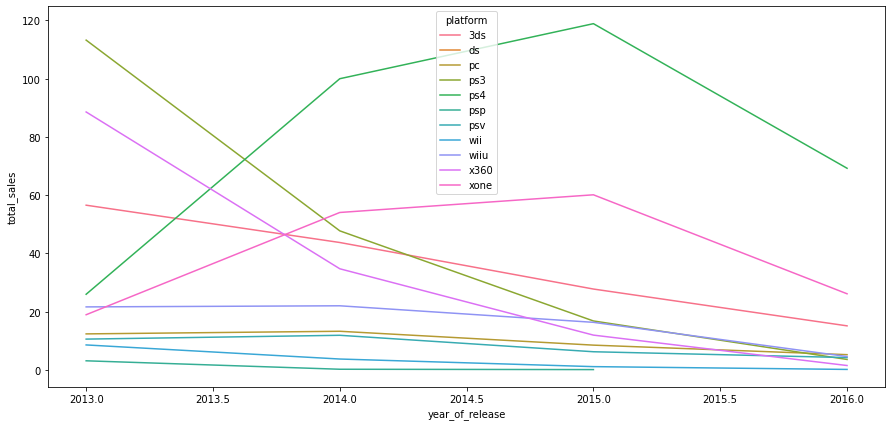

In [29]:
# получение таблицы
data_to_plot = data_actual.pivot_table(index = ['platform', 'year_of_release'],
                                                     values = 'total_sales',
                                                     aggfunc = 'sum'
                                                    )

# построение графика
plot = sns.lineplot(data = data_to_plot.reset_index(),
                    x = 'year_of_release',
                    y = 'total_sales',
                    hue = 'platform',
                    )
plot.figure.set_figwidth(15)
plot.figure.set_figheight(7)

**Вывод по вопросу 3:** Судя по данным продаж в 2016-ом, лидирующими платформами являются 2 приставки актуального на тот момент поколения, а также одна карманная:
- **PS4**
- **Xbox One**
- **Nintendo 3DS**

Выберем указанные платформы как 3 самые прибыльные, на графике они выражены наиболее ярко - остальные по продажам находятся почти на одном уровне. Примечательно еще то, что даже по ним наблюдается спад продаж - как было замечено в вопросе 1, рынок в целом падает после 2010-го.

**Вопрос 4**

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам и проанализируем результат.

In [30]:
# создание функции для построения boxplot-ов
def any_boxplot(title, ylim, query):
    if query == None:
        boxplot = data_actual.boxplot(column = 'total_sales',
                               figsize = (10, 15),
                               )
        plt.title(title)
        boxplot.set_ylim(ylim)
    
    else:
        boxplot = data_actual.query(query).boxplot(column = 'total_sales',
                                            by = query.split()[0],
                                            figsize = (10, 15),
                                           )
        plt.title(title)
        boxplot.set_ylim(ylim)
        
    return boxplot

<AxesSubplot:title={'center':'Общая диаграмма по глобальным продажам игр'}>

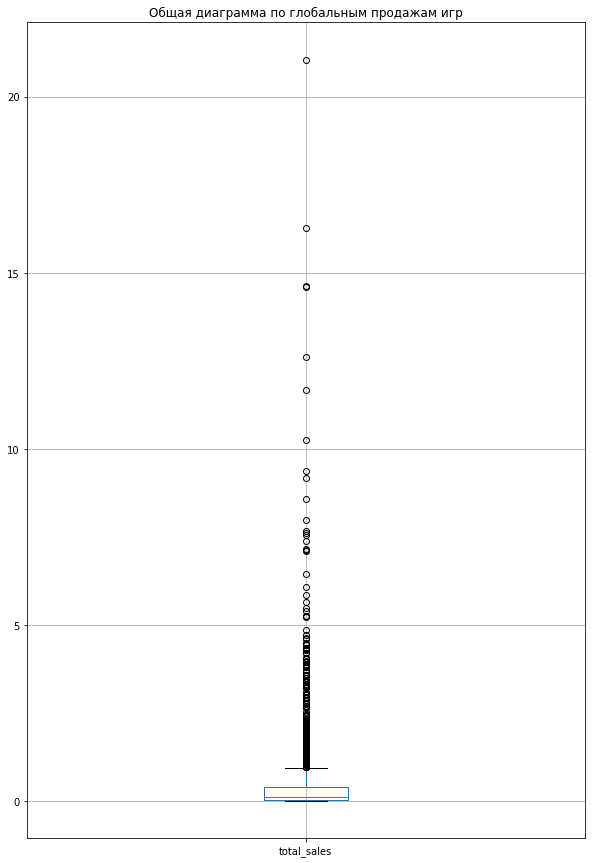

In [31]:
# boxplot по общим глоальным продажам
any_boxplot('Общая диаграмма по глобальным продажам игр', ylim = None, query = None)

<AxesSubplot:title={'center':'Общая диаграмма по глобальным продажам игр'}>

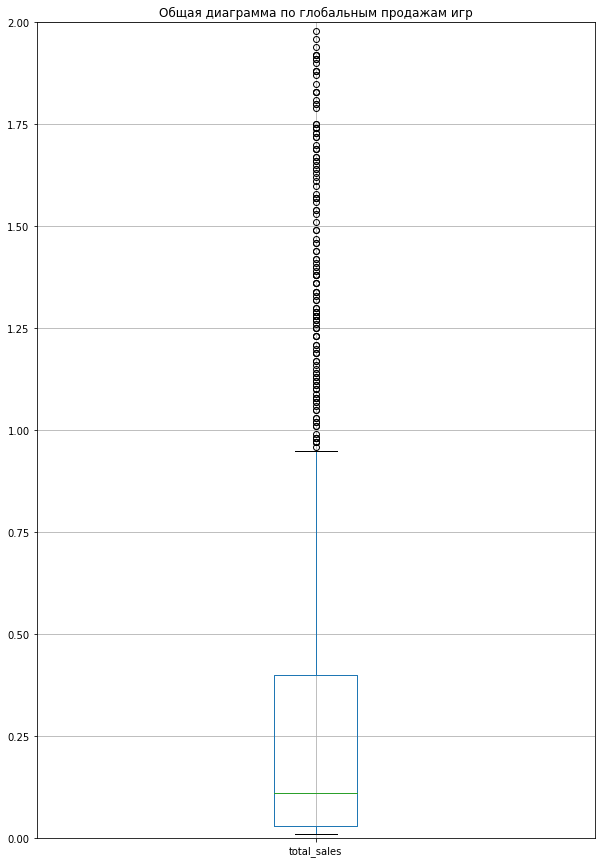

In [32]:
# boxplot по общим глоальным продажам. Чуть ближе
any_boxplot('Общая диаграмма по глобальным продажам игр', ylim = [0, 2], query = None)

Судя по графику, средняя сумма продаж каждой игры находится в пределах 0,9 млн долларов. 

Медианное значение - в районе 0,15 млн долларов. 

Это совсем немного - в общей статистике присутствует много локальных и не популярных релизов. При этом есть много выбросов в положительную сторону - при успешном релизе прибыль с одной игры может быть существенно выше остальных.

<AxesSubplot:title={'center':'Диаграмма по глобальным продажам на самых популярных платформах'}, xlabel='platform'>

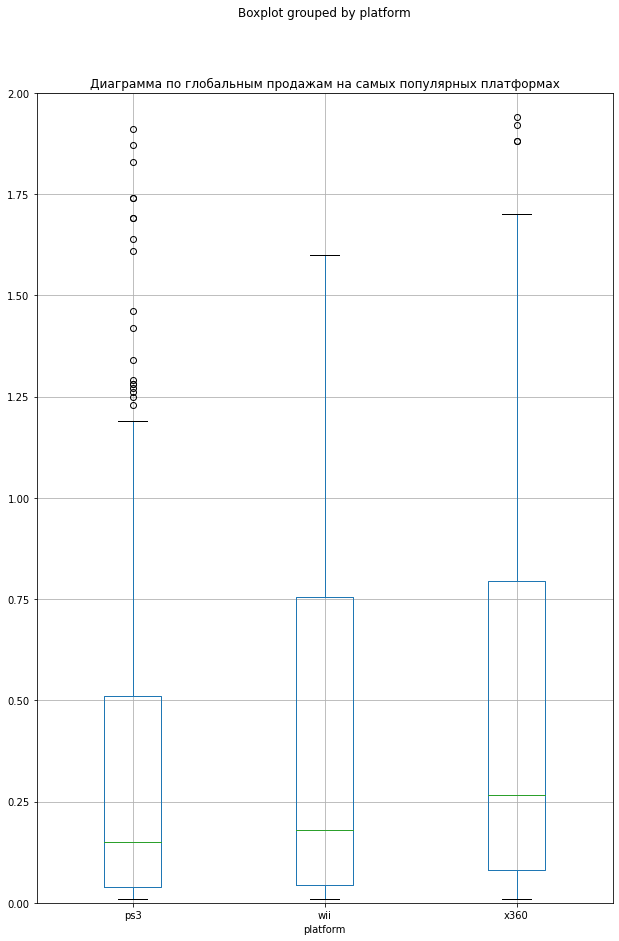

In [33]:
# boxplot по глобальным продажам на самых популярных платформах
# используем ранее созданный список top_platforms_global из вопроса 2
any_boxplot('Диаграмма по глобальным продажам на самых популярных платформах',
            ylim = [0, 2],
            query = 'platform in @top_platforms_global')

<AxesSubplot:title={'center':'Диаграмма по глобальным продажам на самых популярных платформах'}, xlabel='platform'>

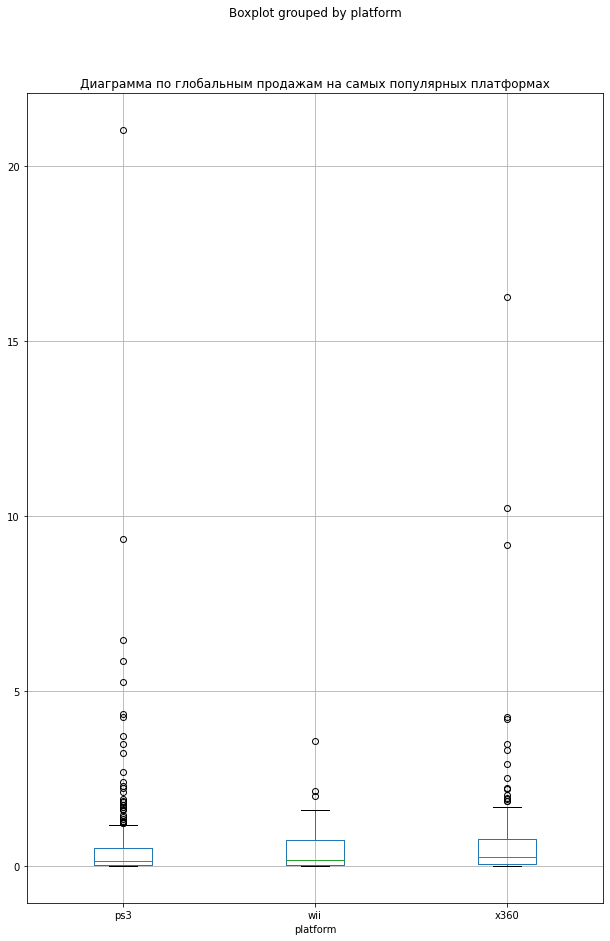

In [34]:
# дополнительный график без ограничения по y. Нужен для понимания полной картины выбросов
any_boxplot('Диаграмма по глобальным продажам на самых популярных платформах',
            ylim = None,
            query = 'platform in @top_platforms_global')

Судя по графику, самые высокие средние продажи происходили у **PS3** и **Xbox360** - на уровне 1,7 млн долларов. У **Nintendo Wii** в районе 1,1 млн долларов. Самые низкие показатели продаж у **Nintendo DS** и **PS2** - менее 1 млн долларов.

Медианные значение похожи по рейтингу средних значений, только в этот раз у **PS2** и **Nintendo Wii** они на одном уровне. Находятся в пределах 0,1 0,3 млн долларов).

При этом наблюдаются выбросы в положительную сторону - в случае очень успешного релиза прибыль с одной игры может быть даже выше 20 млн долларов.

Для интереса, посмотрим данные по самым популярным платформам на конец 2016 года.

<AxesSubplot:title={'center':'Диаграмма по глобальным продажам на самых популярных платформах 2016 года'}, xlabel='platform'>

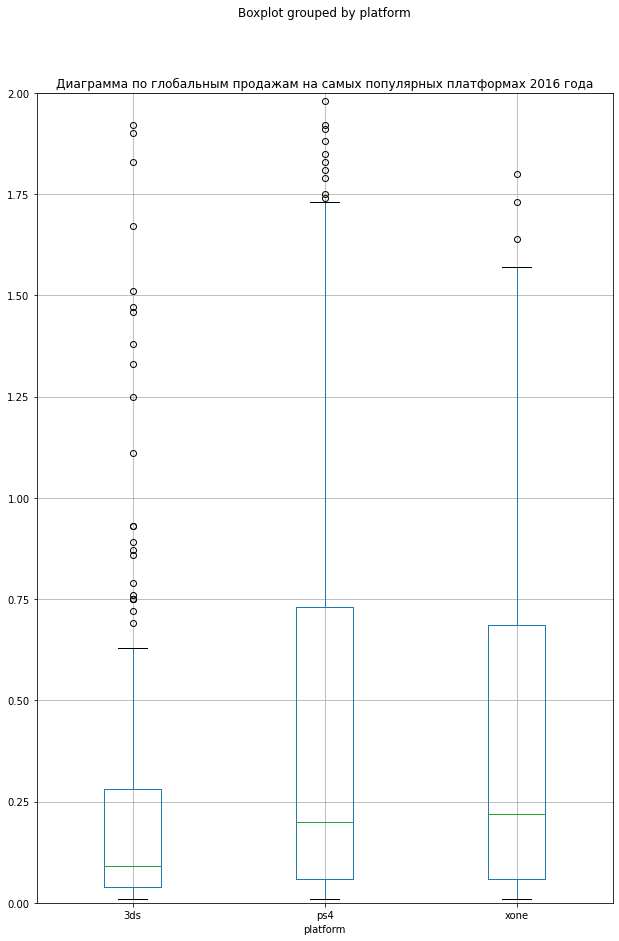

In [35]:
# формирование нового списка с популярными платформами 2016-го
top_platforms_2016 = ['ps4', 'xone', '3ds']

# boxplot по глобальным продажам на самых популярных платформах 2016-го
any_boxplot('Диаграмма по глобальным продажам на самых популярных платформах 2016 года',
            ylim = [0, 2],
            query = 'platform in @top_platforms_2016')

<AxesSubplot:title={'center':'Диаграмма по глобальным продажам на самых популярных платформах 2016 года'}, xlabel='platform'>

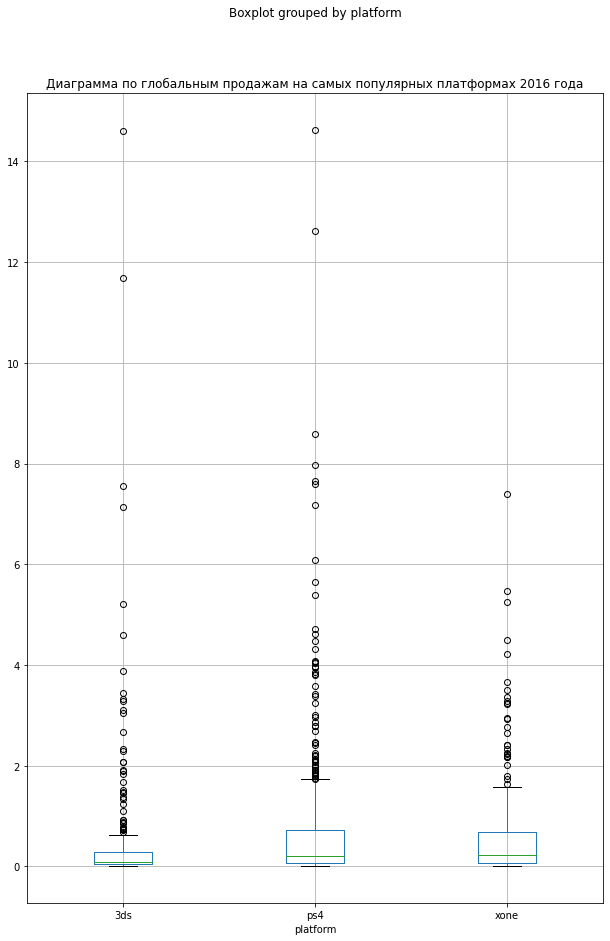

In [36]:
# boxplot по глобальным продажам на самых популярных платформах 2016-го. Общая картина
any_boxplot('Диаграмма по глобальным продажам на самых популярных платформах 2016 года',
            ylim = None,
            query = 'platform in @top_platforms_2016')

На текущих платформах показатели отличаются - PS4 преобладает в популярности. Более того, у Nintendo 3DS средние продажи игры вовсе не превышают 0,75 млн долларов.

В текущих реалиях Nintendo очень сильно проигрывает Sony и Microsoft на рынке, а Microsoft проигрывает Sony.

При этом на каждой платформе нтакже наблюдались единичные суперуспешные релизы. Данных по PS4 и Xbox One может быть недостаточно, тк на момент 2016-го приставки только вышли и набрали пик.

**Вывод по вопросу 4:** В среднем, сумма продаж с каждой игры на всех платформах находится в пределах 0,9 млн долларов, медианное значение находится в районе 0,15 млн долларов. На самых популярных платформах ситуация чуть лучше, средняя выручка с PS4 ближе к 1,8 млн долларов, 0,2 - общее медианное значение (также чуть выше). Существенного роста нет, тк на 2016 год переход между поколениями только завершился и полноценных громких эксклюзивов еще не было.

В любом случае, на каждой платформе возможно выпустить очень успешную игру, которая станет хитом и принесет существенную прибыль, гораздо большую средней.

**Вопрос 5**

В этом вопросе посмотрим, влияют ли оценки критиков и игроков на продажи игр. Для этого возьмем одну из самых популярных платформ - **PS3**. Даже на конец периода в данных (2016-ый) она являлась очень популярной, на ней вышло много эксклюзивов и все топовые мультиплатформенные игры.

In [37]:
# получение среза по PS3 с присутствующими оценками критиков и игроков
data_ps3 = data_actual[(data_actual['platform'] == 'ps3') &
                (data_actual['critic_score'] > 0) &
                (data_actual['user_score'] > 0)
               ]

In [38]:
# создание функции для построение диаграммы рассеяния по оценкам критиков и оценкам пользователей
def scores_scatter(score_column):
    plot = data_ps3.plot(kind = 'scatter',
                         x = score_column,
                         y = 'total_sales',
                         figsize = (10, 7),
                        )
    return plot

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

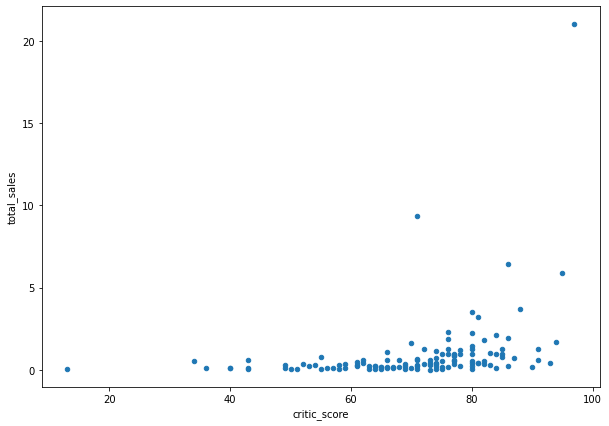

In [39]:
# диаграмма рассеяния - влияние оценок критиков на продажи
scores_scatter('critic_score')

Оценки критиков довольно сильно влияют на продажи игр. Замечаем, что начиная с 70 баллов из 100 продажи довольно сильно растут.

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

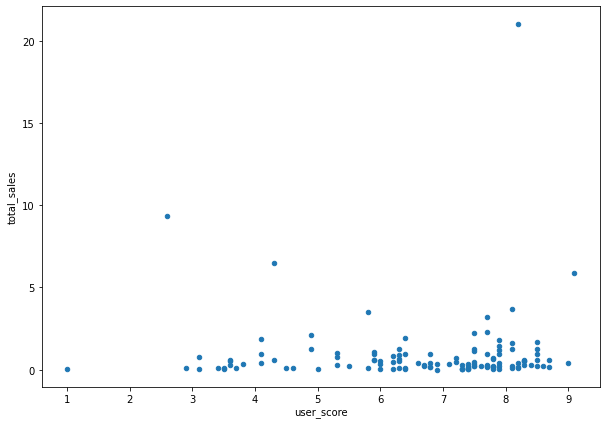

In [40]:
# диаграмма рассеяния - влияние оценок игроков на продажи
scores_scatter('user_score')

По игрокам ситуация отличается. Даже игры с невысокими оценками игроков могут хорошо продаваться - разработчики могут очень сильно подогреть интерес к игре до релиза и побудить игроков оформлять предзаказы. Разочаровавшись на релизе и отдав разработчикам свои деньги, игроки начинают выставлять невысокие оценки игре. Самые яркие примеры из реальности - это Киберпанк 2077 в декабре 2020-го или очередной Battlefield, начиная с Battlefield V.

In [41]:
# создание функции для построения тепловых карт по популярным платформам
def top_platforms_heatmap(platform):
    title_dict = {'ps3':'Платформа PS3',
                  'x360':'Платформа Xbox360',
                  'ps4':'Платформа PS4', 
                  'xone':'Платформа Xbox One',
                  '3ds':'Платформа Nintendo 3DS'
                 }
    
    data_platform = data_actual[(data_actual['platform'] == platform) & 
                         (data_actual['critic_score'] > 0) & 
                         (data_actual['user_score'] > 0)]
    
    plot = sns.heatmap(data_platform[['total_sales', 'critic_score', 'user_score']].corr()[['total_sales']]
                       .sort_values(by='total_sales', ascending=False), 
                       annot = True, 
                      )
    
    plt.title(title_dict[platform])
    
    return plot

<AxesSubplot:title={'center':'Платформа PS3'}>

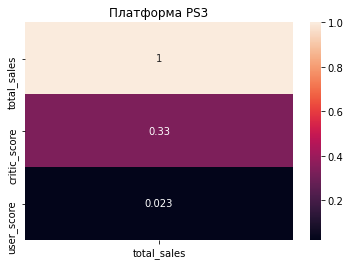

In [42]:
# тепловая карта для PS3
top_platforms_heatmap('ps3')

Исходя из хитмепа, более сильно на продажи игр влияют именно оценки критиков - это крупные издания по игровой тематике (например, Metalcritic), которые являются лидерами мнений.

По значениям коэффициента корреляции, тем не менее на продажи оценки критиков влияют очень слабо, судя по значению 0,33.

Оценки игроков на продажи не влияют, корреляция отсутствует - значение коэффициента 0,023 очень мало.

**Проверим, являются ли выводы такими же для других популярных платформ**

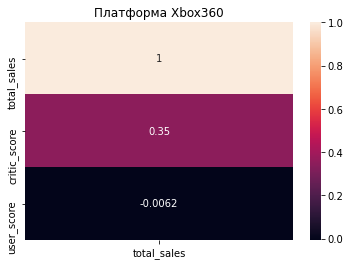

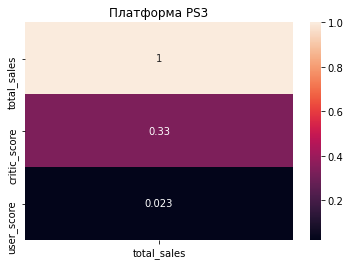

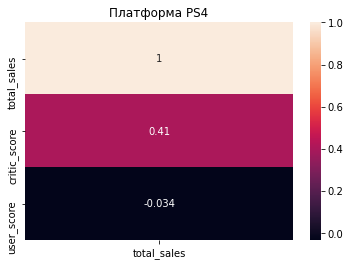

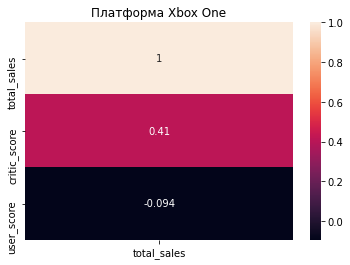

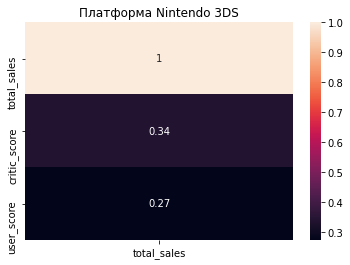

In [43]:
# создание цикла для построения тепловых карт. Еще небольшая автоматизация функции
# создадим новый список с учетом глобально популярных платформ, а также популярным на конец 2016-го

top_platforms = ['x360', 'ps3', 'ps4', 'xone', '3ds']

for platform in top_platforms:
    top_platforms_heatmap(platform)
    plt.show()

**Вывод по вопросу 5:** В случае оценок критиков и игроков, сильнее на продажи игр влияют именно оценки критиков на всех платформах, так как именно они являются лидерами мнений. Также они могут оказаться и "продажными", помогая пиарить какую-либо игру вместе с разработчиками. Плохие оценки пользователей при высоких продажах возникают из-за разочарования игрой на релизе. Высокие продажи происходят благодаря большому количеству предзаказов.

В целом по значениям коэффициентов, корреляция между продажами и оценками критиков является очень малой, но существует. Корреляция между продажами и оценками игроков - отсутствует.

В случае Nintendo 3DS наблюдается аномалия: оценки критиков и игроков влияют на продажи игр почти в равной степени. Может быть так, что платформы более локальные в Японии, и там игроки могут плотнее обмениваться мнениями. Но несмотря на это, корреляции очень слабые и в целом оценки аудитории на общую картину продаж влияют очень слабо.

**Вопрос 6**

В рамках этого вопроса посмотрим подробнее на жанры игр и определим самые популярные.

Для начала, построим график с продажами и общим количеством игр по каждому жанру. На этапе предобработки пропуски значений в столбце устранены.

<AxesSubplot:xlabel='genre'>

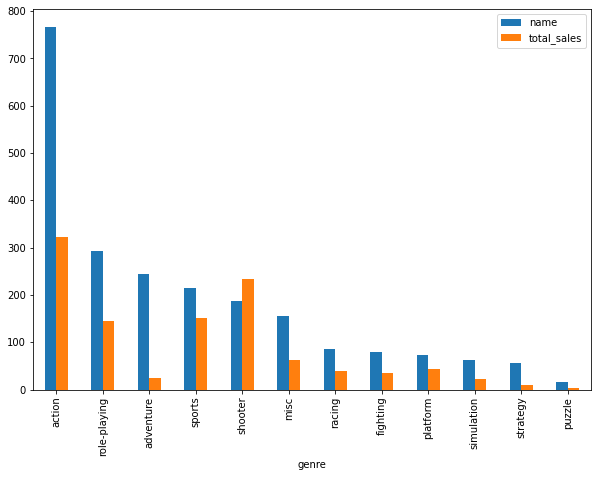

In [44]:
# создание новой таблицы по количеству игр жанра и сумм продаж
data_genre = data_actual.groupby('genre').agg({'name':'count','total_sales':'sum'}).sort_values(by='name', ascending=False)

# построение графика
data_genre.plot(kind = 'bar',
                figsize = (10, 7))


**Вывод по вопроу 6:** Самыми популярными жанрами являются экшен, ролевой, приключения и спортивный; самыми кассовыми - экшен, шутеры, спортивный и ролевой.

Примечательно, что при бешеной популярности экшенов продажи у них не сильно выше на фоне остальных. Это может быть связано с тем, что экшены более популярны на ПК, где еще присутствует пиратство. Аналогичная картина наблюдается у приключенческих игр - популярность выше чем у спортивных, но уровень продаж на уровне симуляторов и файтингов (неужели Анчартед пиратили, игра же шедевр...). Еще примечательно, что шутеры почти не пиратят - при разнице популярности с экшенами почти в 4 раза, продажи уступают не более, чем на 20% (на глаз).

**Общий вывод по исследовательскому анализу данных**

На этапе исследовательского анализа данных ответили на 6 вопросов, ключевые выводы можно сформулировать так:
- 1) Общий тренд индустрии - рынок падает с 2010-ых, количество релизов уменьшается со временем;
- 2) Самыми популярными платформами за все время являются: 3 первых поколения стационарных PlayStation (PS-PS3), стационарная Nintendo Wii и карманная DS, а также стационарная Xbox360. Средний срок жизни платформы составляет 10 лет, затем происходит окончательная смена поколений;
- 3) Выбранный актуальный период для построение прогноза продаж на 2017-ый - статистика с 2013-го по 2016-ый - в этот период попали самые актуальные платформы, которые еще не раскрылись полностью и не попали те, "эра" которых уже ушла;
- 4) На конец 2016-го лидирующими платформами по продажам оказались стационарные PS4, Xbox One и карманная Nintendo 3DS;
- 5) В среднем, сумма продаж с каждой игры на одной платформе приносит 0,9 млн долларов, медианное значение продаж - в пределах 0,15 млн долларов. На каждой платформе были и суперуспешные релизы с прибылью 5+ млн долларов (иногда и 20+);
- 6) Оценки критиков в большей степени влияют на уровень продаж игр, по сравнению с оценками пользователей. Оценки критиков влияют очень слабо, оценки игроков - не влияют на общую картину продаж;
- 7) Самыми популярными и кассовыми жанрами игр являются экшен, шутеры, спортивный и ролевой.

## Портрет пользователей регионов NA, EU и JP

В этом разделе ответим на 3 вопроса по пользователям в каждом регионе (Северная Америка, Европа и Япония):
- 1) Какие платформы самые популярные (топ-5) и есть ли различия в долях продажах?
- 2) Какие жанры самые популярные (топ-5) и есть ли различия между регионами?
- 3) Влияет ли рейтинг ESRB на продажи в каждом регионе?

Для ответа на каждый вопрос стоит подготовить функцию, на вход которой будет подаваться отдельный регион и параметр для сравнения, на выводе будет столбчатая диаграмма по региону.

In [45]:
# подготовка функции для построения графиков
def criterio_plot(sales_region, criterio):
    title_dict = {'na_sales':'Продажи в Северной Америке',
                  'eu_sales':'Продажи в Европе',
                  'jp_sales':'Продажи в Японии'
                 }
    
    pivot_to_plot = data_actual.groupby(criterio).agg({sales_region:'sum'}).sort_values(by=sales_region, ascending=False)[:5]
    
    plot = pivot_to_plot.plot(kind = 'bar',
                              title = title_dict[sales_region],
                             )
    
    return plot

In [46]:
# добавление дополнительной категоризации
def platform_categories(platform):
    if platform == '3ds':
        return '3ds'
    if platform == 'ps3':
        return 'ps3'
    if platform == 'psv':
        return 'psv'
    if platform == 'ps4':
        return 'ps4'
    if platform == 'wiiu':
        return 'wiiu'
    else:
        return 'other platform'

data_actual['platform_category'] = data_actual['platform'].apply(platform_categories)

**Вопрос 1**

Посмотрим на статистику по продажам на различных платформах. Выведем все 3 графика в одной ячейке.

<AxesSubplot:title={'center':'Продажи в Японии'}, xlabel='platform_category'>

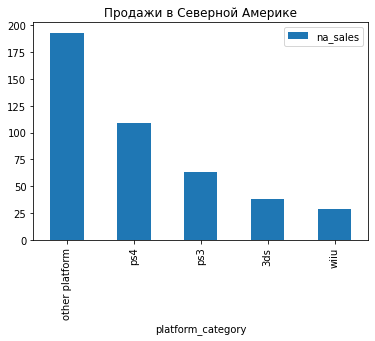

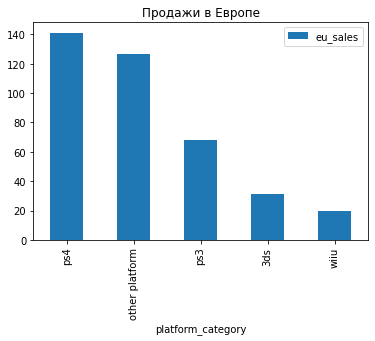

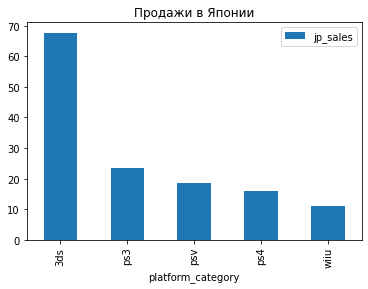

In [47]:
# вызов функции для платформ
criterio_plot('na_sales', 'platform_category')
criterio_plot('eu_sales', 'platform_category')
criterio_plot('jp_sales', 'platform_category')

**Вывод по вопросу 1**

Судя по графику популярности платформ:
- В Северной Америке самыми популярными на фоне всех остальных являлись представители Sony и Nintendo: это **PS4**, **PS3**, **Nintendo Wii U**. Самой популярной карманной платформой была **Nintendo DS**;
- В Европе серьезную популярность имеет семейство **PS4** и **PS3** (первые топ-2 на фоне всех остальных), менее популярны Nintendo: **Nintendo 3DS** и **Nintendo Wii U**;
- В Японии существенную популярность имеют карманные платформы в виде **Nintendo DS**, следом идут **PS3**, **PS Vita** и **PS4**. Также в топе **Nintendo Wii U**.

**Вопрос 2**

Посмотрим на статистику по популярности различных жанров. Выведем все 3 графика в одной ячейке.

<AxesSubplot:title={'center':'Продажи в Японии'}, xlabel='genre'>

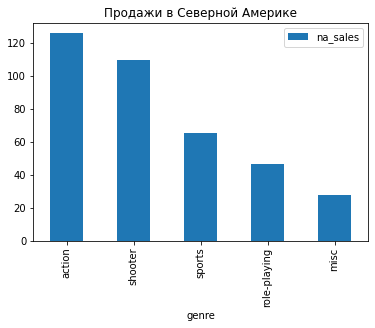

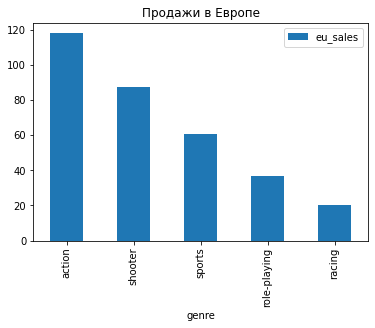

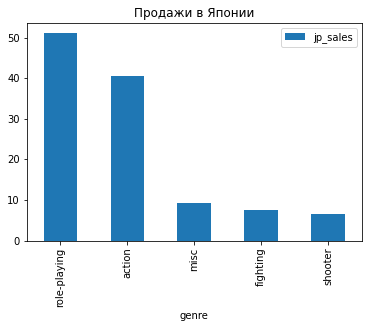

In [48]:
# вызов функции для жанров
criterio_plot('na_sales', 'genre')
criterio_plot('eu_sales', 'genre')
criterio_plot('jp_sales', 'genre')

**Вывод по вопросу 2**

Судя по графику популярности жанров:
- В Северной Америке и Европе самыми популярными жанрами являются **экшен** и **шутеры**, а также **спортивные игры** и **ролевые игры**. Тренд наблюдается один;
- Тем не менее, в Северной Америке более популярны **мультиплатформенные игры**, а в Европе - **гонки**.
- В Японии преобладают **ролевые игры** и **экшен**. Затем, но с очень существенным отставанием популярны **мультижанр** и **файтинги** (неудивительно, ведь Tekken и Street Fighter вроде японские игры).

**Вопрос 3**

Посмотрим на статистику по присвоенному рейтингу ESRB. Выведем все 3 графика в одной ячейке.

Вспомним категории рейтинга:
- AO - Только для взрослых (18+ лет, выше чем M);
- E - Для всех;
- M - Для взрослых (17+ лет);
- T - Подросткам (13+ лет);
- E10+ - Для всех от 10 лет и старше;
- K-A - Kids to Adults. *Произведена замена на E при предобработке*;
- EC - Для детей младшего возраста (от 3 лет);
- RP - Рейтинг ожидается, обычно применяется ДО релиза игр.

<AxesSubplot:title={'center':'Продажи в Японии'}, xlabel='esrb_rating'>

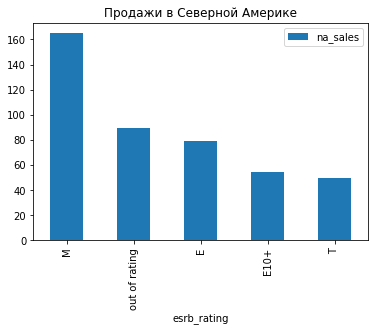

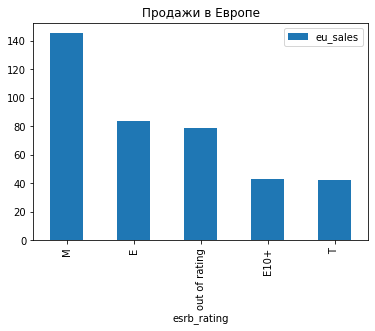

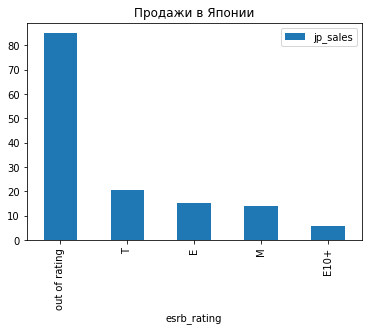

In [49]:
# вызов функции для рейтингов
criterio_plot('na_sales', 'esrb_rating')
criterio_plot('eu_sales', 'esrb_rating')
criterio_plot('jp_sales', 'esrb_rating')

**Вывод по вопросу 3**

Судя по графику рейтинга ESRB:
- В каждом регионе лидирующими рейтингами являются E, E10+, M и T - мировой рынок игр ориентирован на детей 10+ лет, подростков и взрослых.
- В Японии существенно преобладает **аудитория подростков** - увлекаться играми там начинают с детства.
- Довольно большому проценту игр рейтинг не присвоен, что может вызывать вопросы касательно их содержания.

**Общий вывод по разделу**

- 1) Платформы PlayStation и Nintendo популярны во всем мире, платформа Xbox не сыскала большой популярности ни в одном регионе;
- 2) Самые популярные жанры в целом по миру - экшен, шутеры и спортивные игры, в Японии очень популярны роелвые игры;
- 3) Основа аудитории во всем мире - это жители 10+лет, в Японии концентрация подростков, увлекающимися играми, выше чем в остальном мире.

## Проверка гипотез

Так как выборки данных не зависимы между собой, предлагается использование t-критерия Стьюдента. Также выборки будут формироваться из столбца `user_score`, в котором изначально были пропуски и не заполнялись - получим срез без пропусков.

In [50]:
# выделение "чистых" данных
clean_data = data_actual[data_actual['user_score'] > 0]
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192 entries, 16 to 16692
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1192 non-null   object 
 1   platform           1192 non-null   object 
 2   year_of_release    1192 non-null   int64  
 3   genre              1192 non-null   object 
 4   na_sales           1192 non-null   float64
 5   eu_sales           1192 non-null   float64
 6   jp_sales           1192 non-null   float64
 7   other_sales        1192 non-null   float64
 8   critic_score       976 non-null    float64
 9   user_score         1192 non-null   float64
 10  esrb_rating        1192 non-null   object 
 11  total_sales        1192 non-null   float64
 12  platform_category  1192 non-null   object 
dtypes: float64(7), int64(1), object(5)
memory usage: 130.4+ KB


### Подготовка данных и выделение выборок

**Гипотеза №1**

**H0**: Средние пользовательские рейтинги платформ Xbox One и PC не отличаются;

**H1**: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Гипотеза о равенстве средних 2-х совокупностей. Необходимы 2 выборки данных по рейтингам отдельно PC и отдельно Xbox One по столбцу `user_score`.

In [51]:
# выделение среза отдельно по PC
pc_user_score = clean_data.query('platform == "pc"')

# информация о срезе
pc_user_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 458 to 16692
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               155 non-null    object 
 1   platform           155 non-null    object 
 2   year_of_release    155 non-null    int64  
 3   genre              155 non-null    object 
 4   na_sales           155 non-null    float64
 5   eu_sales           155 non-null    float64
 6   jp_sales           155 non-null    float64
 7   other_sales        155 non-null    float64
 8   critic_score       148 non-null    float64
 9   user_score         155 non-null    float64
 10  esrb_rating        155 non-null    object 
 11  total_sales        155 non-null    float64
 12  platform_category  155 non-null    object 
dtypes: float64(7), int64(1), object(5)
memory usage: 17.0+ KB


In [52]:
# выделение среза отдельно по Xbox One
xone_user_score = clean_data.query('platform == "xone"')

# информация о срезе
xone_user_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 165 to 16660
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               182 non-null    object 
 1   platform           182 non-null    object 
 2   year_of_release    182 non-null    int64  
 3   genre              182 non-null    object 
 4   na_sales           182 non-null    float64
 5   eu_sales           182 non-null    float64
 6   jp_sales           182 non-null    float64
 7   other_sales        182 non-null    float64
 8   critic_score       165 non-null    float64
 9   user_score         182 non-null    float64
 10  esrb_rating        182 non-null    object 
 11  total_sales        182 non-null    float64
 12  platform_category  182 non-null    object 
dtypes: float64(7), int64(1), object(5)
memory usage: 19.9+ KB


**Гипотеза №2**

**H0**: Средние пользовательские рейтинги жанров Action и Sports не отличаются.

**H1**: Средние пользовательские рейтинги жанров Action и Sports отличаются.

Гипотеза о равенстве средних 2-х совокупностей. Необходимы 2 выборки данных по рейтингам отдельно Action и отдельно Sports по столбцу `user_score`.

In [53]:
# выделение среза отдельно по Action
action_user_score = clean_data.query('genre == "action"')

# информация о срезе
action_user_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 16 to 16692
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               389 non-null    object 
 1   platform           389 non-null    object 
 2   year_of_release    389 non-null    int64  
 3   genre              389 non-null    object 
 4   na_sales           389 non-null    float64
 5   eu_sales           389 non-null    float64
 6   jp_sales           389 non-null    float64
 7   other_sales        389 non-null    float64
 8   critic_score       309 non-null    float64
 9   user_score         389 non-null    float64
 10  esrb_rating        389 non-null    object 
 11  total_sales        389 non-null    float64
 12  platform_category  389 non-null    object 
dtypes: float64(7), int64(1), object(5)
memory usage: 42.5+ KB


In [54]:
# выделение среза отдельно по Sports
sports_user_score = clean_data.query('genre == "sports"')

# информация о срезе
sports_user_score.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 77 to 16643
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               160 non-null    object 
 1   platform           160 non-null    object 
 2   year_of_release    160 non-null    int64  
 3   genre              160 non-null    object 
 4   na_sales           160 non-null    float64
 5   eu_sales           160 non-null    float64
 6   jp_sales           160 non-null    float64
 7   other_sales        160 non-null    float64
 8   critic_score       110 non-null    float64
 9   user_score         160 non-null    float64
 10  esrb_rating        160 non-null    object 
 11  total_sales        160 non-null    float64
 12  platform_category  160 non-null    object 
dtypes: float64(7), int64(1), object(5)
memory usage: 17.5+ KB


**Вывод:** необходимые данные для проверки гипотез получены, можно приступать к самой проверке.

- 1) Для гипотезы №1 - `pc_user_score` и `xone_user_score`;
- 2) Для гипотезы №2 - `action_user_score` и `sports_user_score`.

### Проверка гипотез

Пороговое значение `alpha` зададим 0.05 - общепринятое значение.

In [55]:
alpha = 0.05

**Гипотеза №1**

**H0**: Средние пользовательские рейтинги платформ Xbox One и PC не отличаются;

**H1**: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [56]:
# получение значений выборки в виде списка
pc_user_score_list = pc_user_score['user_score'].to_list()
xone_user_score_list = xone_user_score['user_score'].to_list()

In [57]:
# проверка гипотезы №1
results = st.ttest_ind(pc_user_score_list, xone_user_score_list)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


**Вывод:** между выборками нет значимых различий, результат может быть получен с 18%-ой вероятностью.

Верно утверждение, что средние пользовательские рейтинги на PC и Xbox One не отличаются. Посмотрим сами цифры.

In [58]:
# вывод средних значений по пользовательским рейтингам на PC и Xbox One
print('Средний пользовательский рейтинг по PC', pc_user_score['user_score'].mean())
print('Средний пользовательский рейтинг по Xbox One', xone_user_score['user_score'].mean())

Средний пользовательский рейтинг по PC 6.2696774193548395
Средний пользовательский рейтинг по Xbox One 6.521428571428572


Действительно, средние рейтинги очень близки друг к другу.

**Гипотеза №2**

**H0**: Средние пользовательские рейтинги жанров Action и Sports не отличаются.

**H1**: Средние пользовательские рейтинги жанров Action и Sports отличаются.

In [59]:
# получение значений выборки в виде списка
action_user_score_list = action_user_score['user_score'].to_list()
sports_user_score_list = sports_user_score['user_score'].to_list()

In [60]:
# проверка гипотезы №2
results = st.ttest_ind(action_user_score_list, sports_user_score_list)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


**Вывод:** между выборками есть значимые различия, разница в рейтингах не случайна.

Верно утверждение, что средние пользовательские рейтинги в жанрах Action и Sport отличаются.

**Вывод по гипотезам**

Приняты 1 нулевая и 1 альтернативная гипотезы.

- В случае платформ могу предположить, что пользовательские рейтинги не отличаются между собой из-за единой подписки Xbox Game Pass для PC (на Windows) и Xbox, также есть возможность прямого подключения геймпада от Xbox к PC - в некоторые игры (иногда жанры, например спорт) не удобно играть на клавиатуре.
- В случае жанров Action и Sports - предположу, что дело в бОльшей степени в управлении - на консолях гораздо удобнее играть в спортивные игры; в случае ПК - в экшен игры, так как они часто предполагают какую-либо стрельбу и точность. Тут гораздо удобнее использовать мышку.

## Общий вывод

В рамках сброного проекта исследованы данные по мировым продажам игр на различных платформах за 2005-2016 годы.

Данные были не совсем полные, понадобилась предобработка - изменены заголовки, типы данных, заполнена часть пропусков в уместных местах. Данные по годам выхода игр, оценкам критиков и пользователей были неполные.

Общий тренд в игровой индустрии - рынок падает с 2010-го, полноценные платформенные игры продаются слабее с каждым годом.

Так как все гонятся за красивой картинкой (судя по популярности жанров экшен) и технологиями, бюджет на разработку заметно вырастает и далеко не все игры получаются успешными - рынок контролируют только крупные студии с большим мешком денег или с инвесторами за спиной (есть шансы на ошибку и исправление). Глубина сюжета и атмосферность игр ценится в большей степени только в Японии, судя по популярности ролевого жанра.

Средний срок жизни одной платформы на рынке составляет 10 лет, за это время технологии и железа, и игр развиваются - происходят переходы между поколениями.

Отвечая на главный вопрос проекта - **выбор оптимальных платформ и построение прогноза на 2017-ый** - при закупке игр стоит планировать на текущее *(на тот момент)* 8-е поколение консолей - это **PS4** и **Xbox One**, а также мобильная **Nintendo 3DS**. Эти платформы находятся в середине "цикла", в этот период как правило происходят самые громкие и успешные релизы - разработчики достаточно хорошо знакомы с самой платформой и понимают все ее технические возможности. 

Для построения прогноза на 2017-ый предлагается выбрать период с 2013-го по причине того, что в этом периоде присутствует полная статистика с момента выхода нового поколения.

Возможный риск - ошибка в планировании закупок лицензий на игры - спрос на новые релизы может оказаться как и слишком большим, так и достаточно низким. В случае высокого спроса - отсутствие необходимого количества игр и потеря игроков, так как они уйдут в другой магазин. В случае низкого спроса - не окупаемость вложений на закупку и убытки.